# PCA 

The goal of the project is to use a dimension reduction approach (PCA, etc.) to decompose and transform high-dimension image data into a (much) lower dimension space for classification and clustering. The dataset can be found here: https://drive.google.com/drive/folders/1FcSHxEKHIyZ_Vckh6K1GDTN-VdM7tgD6 

For each subtask listed below, find the best two eigenvectors that define a 2D space to best separate corresponding categories, visualize individual data points in a 2D plot and calculate a Silhouette score
for each subtask. <br>

Subtask 1. Emotion recognition <br>
Subtask 2. Mask detection <br>
Subtask 3. Person identification <br>

Bonus points: Instead of using a whole image, you are encouraged to try other (creative) ways to solve each problem. A better solution should have a lower Silhouette score than the default one. Even if you may not be able to implement an idea you come up with, you will earn extra points by clearly describing a new idea and explaining in what ways it may improve performance. <br>

Write a report to explain your results and summarize what you’ve learned by trying to find the best dimension reduction solution for each problem.

# Contents
[Method 1: Grayscale image](#method1) <br>
[Method 2: Edges](#method2) <br>
[Method 3: Crop Image](#method3) <br>


# Load data

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame()

In [2]:
data_dir = '/Users/mcmahonmc/Github/machine-learning-2021/02_pca/processed/'

img_files = sorted(glob.glob(data_dir + '*.jpg'))
print('We have %.f images total' % len(img_files))

We have 112 images total


In [3]:
data = pd.DataFrame({'person': [file.split('processed/')[1].split('_')[0] for file in img_files],
                     'emotion': [file.split('processed/')[1].split('_')[1] for file in img_files],
                     'mask': [file.split('processed/')[1].split('_')[2].split('.jpg')[0] for file in img_files]})

data['emotion'] = data['emotion'].replace(['A', 'H', 'N', 'S'], ['Angry', 'Happy', 'Neutral', 'Sad'])
data['mask'] = data['mask'].replace(['M', 'N'], ['Mask', 'No Mask'])

data

person  emotion     mask
0      AMR    Angry     Mask
1      AMR    Angry  No Mask
2      AMR    Happy     Mask
3      AMR    Happy  No Mask
4      AMR  Neutral     Mask
..     ...      ...      ...
107     ZM    Happy  No Mask
108     ZM  Neutral     Mask
109     ZM  Neutral  No Mask
110     ZM      Sad     Mask
111     ZM      Sad  No Mask

[112 rows x 3 columns]

(265, 200)


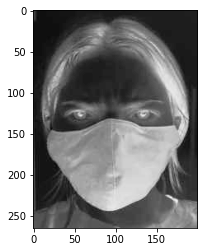

In [4]:
img0 = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
print(img0.shape)
plt.imshow(img0, cmap='Greys')

In [5]:
images = np.zeros((265,200))

for img_file in img_files:
    images = np.dstack((images, cv2.imread(img_file ,cv2.IMREAD_GRAYSCALE)))

images = images[:,:,1:]
images = np.transpose(images, (2, 0, 1))
n_samples, h, w = images.shape
print(images.shape)                

(112, 265, 200)


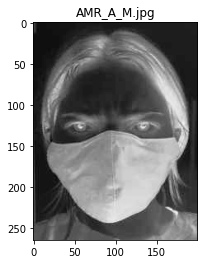

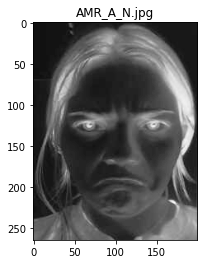

In [6]:
plt.imshow(images[0], cmap='Greys')
plt.title(img_files[0].split('processed/')[1])
plt.show()

plt.imshow(images[1], cmap='Greys')
plt.title(img_files[1].split('processed/')[1])
plt.show()

In [7]:
X = images.reshape((112,-1))
n_features = X.shape[1]

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Method 1: Grayscale Image <a id='method1'></a>

## Subtask 1. Emotion recognition

In [9]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  4


In [10]:
def plot_gallery(images, titles, h, w, n_samples=images.shape[0], n_col = 4):
    n_row = math.ceil(n_samples/n_col)
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =1, hspace =.55)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(str(titles[i]).replace(' ', '\n'), size = 10)
        plt.xticks(()); plt.yticks(())


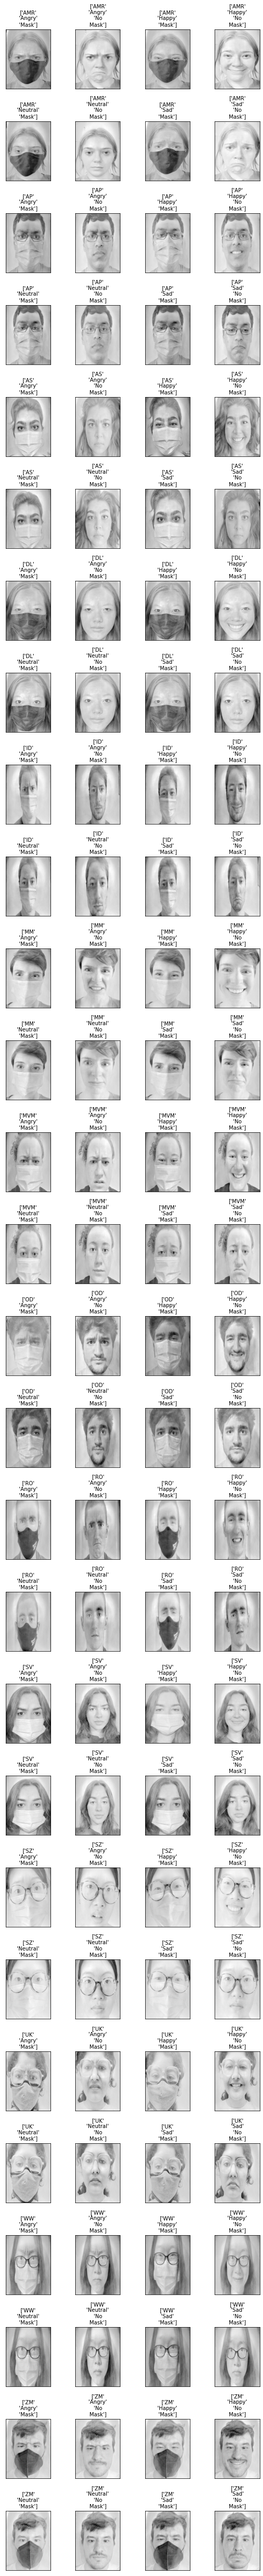

In [11]:
titles = np.array(data)

plot_gallery(X, titles, h, w)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


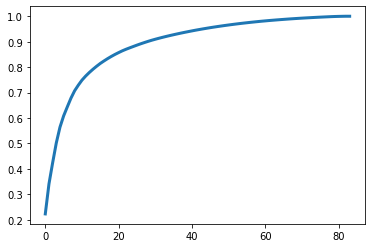

In [13]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [14]:
np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]

14

In [15]:
# n_components = 14
n_components = 10

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Projecting the input data on the eigenfaces orthonormal basis


In [16]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.18      0.50      0.26         6
       Happy       0.00      0.00      0.00         8
     Neutral       0.00      0.00      0.00         8
         Sad       0.00      0.00      0.00         6

    accuracy                           0.11        28
   macro avg       0.04      0.12      0.07        28
weighted avg       0.04      0.11      0.06        28



In [17]:
X_test.shape[0]-1

27

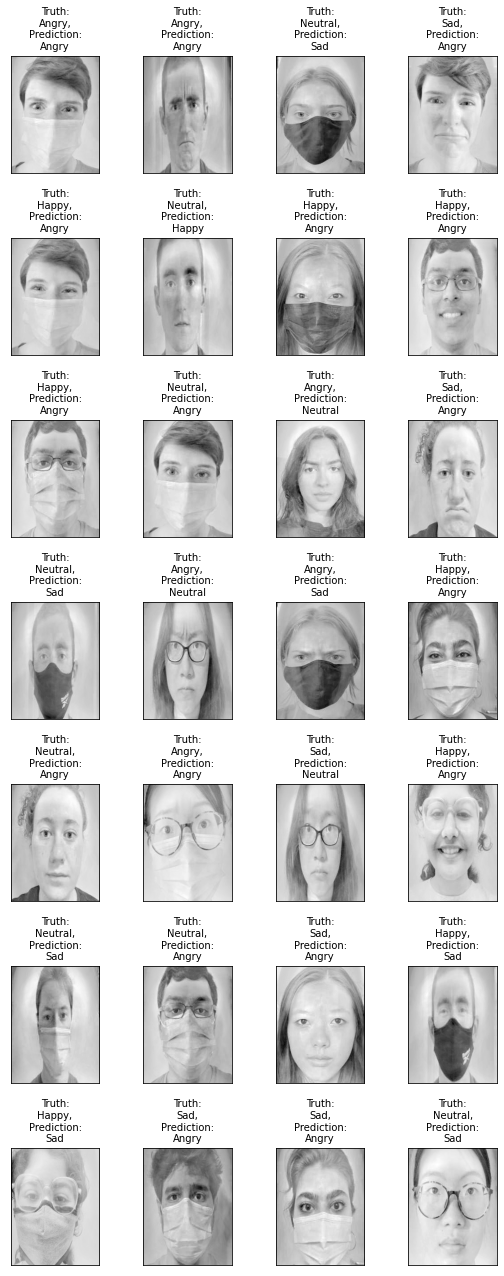

In [18]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

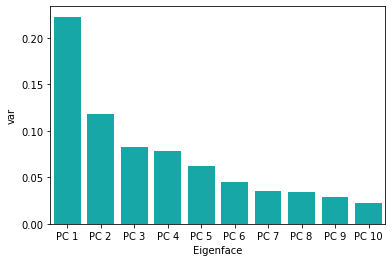

In [19]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [20]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.197991  0.731570 -0.086848  1.982619 -0.850648 -0.055659  1.038120   
1 -0.572764  0.494467 -0.576120 -1.034148  0.343038 -1.458500  0.337017   
2 -0.820833 -1.839788  1.660373 -1.297841 -0.775267  0.204556  0.755455   
3 -0.340118  0.450105 -1.037790  1.311255 -0.451103  0.012066 -0.594225   
4 -0.196241  0.522305 -0.184071  1.814327 -0.649057 -0.269880  1.295130   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0 -0.782181  0.252531 -0.522024    Angry  
1  0.654153 -0.055257 -1.025393    Angry  
2 -0.062681 -0.011385  1.545557    Happy  
3 -0.071447  0.337978 -0.906036    Happy  
4 -0.817540 -0.109250 -0.575624  Neutral

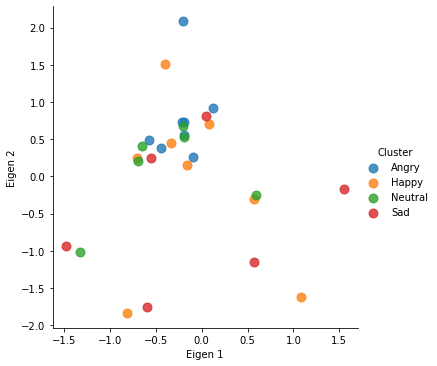

In [21]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [22]:
results = results.append({'subtask': 'emotion', 
                          'method': '1-raw', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: -0.037


## Subtask 2. Mask recognition

In [23]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  2


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))

size of training Data is  84 and Testing Data is  28


In [25]:
pca = PCA().fit(X_train)

# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [26]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.85      0.69      0.76        16
     No Mask       0.67      0.83      0.74        12

    accuracy                           0.75        28
   macro avg       0.76      0.76      0.75        28
weighted avg       0.77      0.75      0.75        28



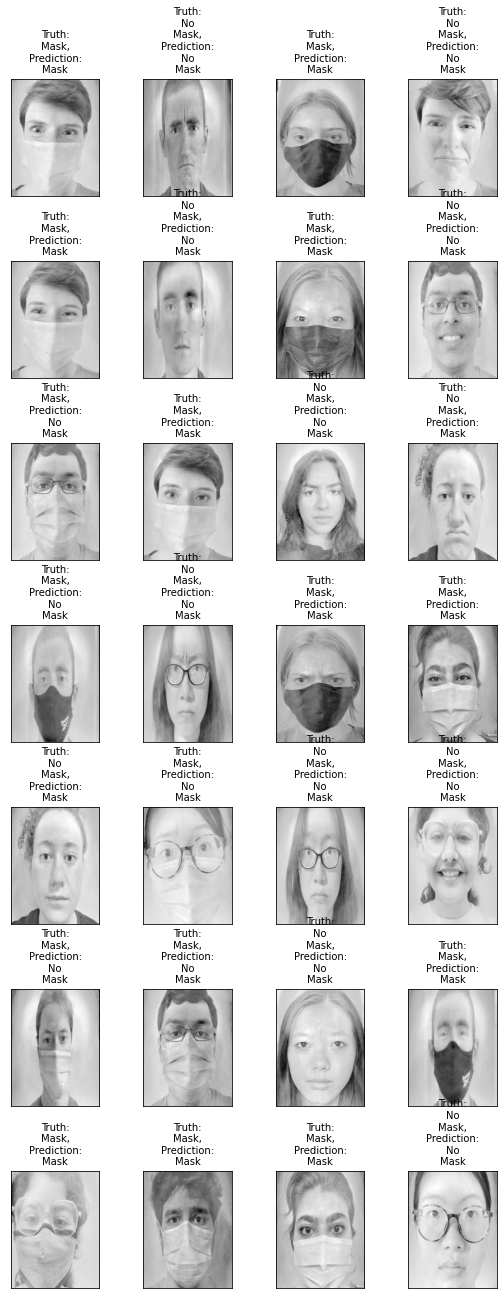

In [27]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

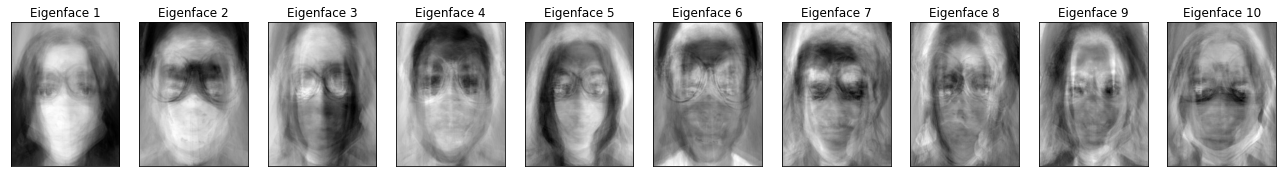

In [28]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

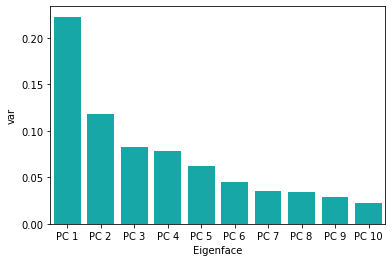

In [29]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [30]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.197991  0.731567 -0.086846  1.982622 -0.850627 -0.055734  1.038805   
1 -0.572764  0.494467 -0.576117 -1.034154  0.343051 -1.458469  0.337629   
2 -0.820833 -1.839789  1.660367 -1.297842 -0.775285  0.204656  0.755602   
3 -0.340118  0.450101 -1.037797  1.311248 -0.451065  0.012097 -0.594009   
4 -0.196241  0.522303 -0.184063  1.814332 -0.649043 -0.269979  1.295990   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0 -0.782546  0.251882 -0.511491     Mask  
1  0.655440 -0.055646 -1.030559  No Mask  
2 -0.062699 -0.011058  1.548759     Mask  
3 -0.071923  0.338103 -0.898676  No Mask  
4 -0.817559 -0.110413 -0.567931     Mask

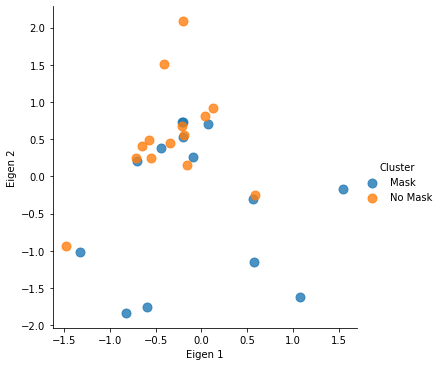

In [31]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [32]:
results = results.append({'subtask': 'mask', 
                          'method': '1-raw', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: 0.006


## Subtask 3. Person recognition

In [33]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  14


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [35]:
pca = PCA().fit(X_train)

# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0] 
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [36]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       1.00      1.00      1.00         2
          AP       1.00      1.00      1.00         3
          AS       0.00      0.00      0.00         2
          DL       1.00      1.00      1.00         2
          ID       1.00      1.00      1.00         1
          MM       1.00      0.25      0.40         4
         MVM       0.67      1.00      0.80         2
          OD       0.25      1.00      0.40         1
          RO       0.80      1.00      0.89         4
          SV       1.00      1.00      1.00         1
          SZ       1.00      1.00      1.00         2
          UK       1.00      1.00      1.00         2
          WW       1.00      1.00      1.00         2

    accuracy                           0.82        28
   macro avg       0.82      0.87      0.81        28
weighted avg       0.85      0.82      0.79        28



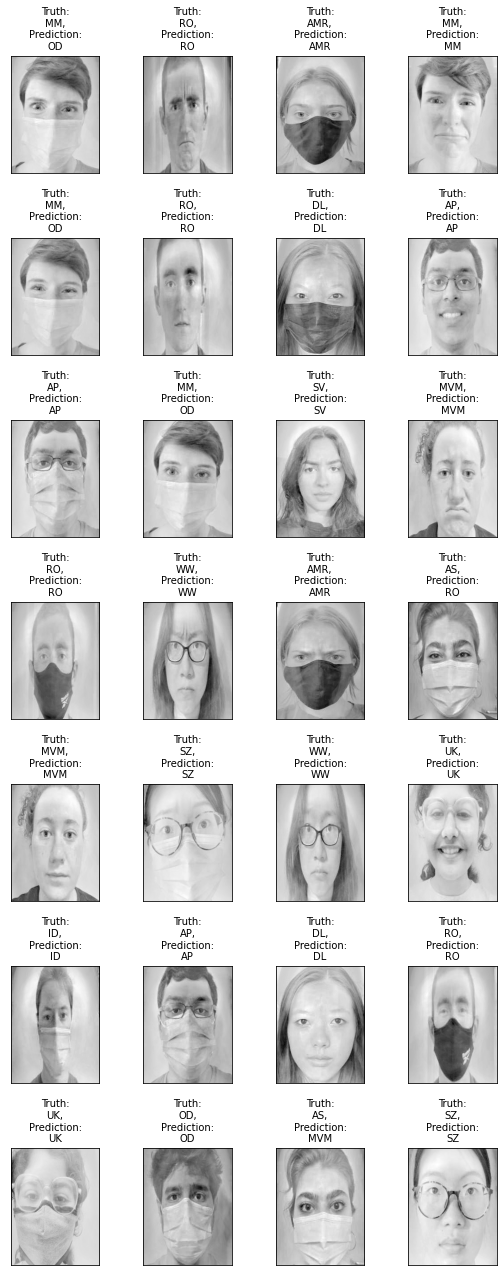

In [37]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

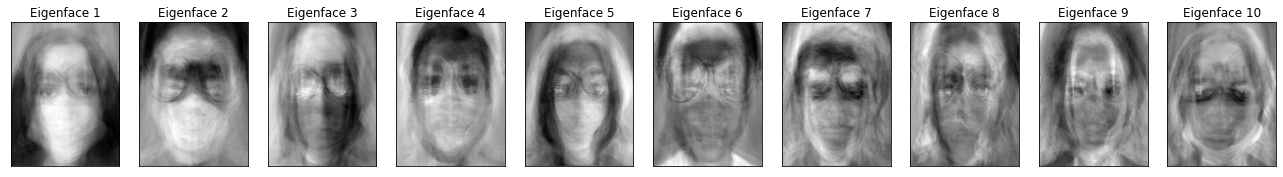

In [38]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

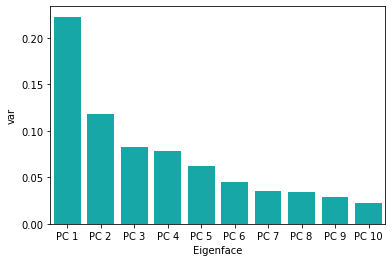

In [39]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [40]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.197991  0.731568 -0.086852  1.982628 -0.850631 -0.055530  1.037989   
1 -0.572764  0.494468 -0.576121 -1.034142  0.343041 -1.458651  0.337033   
2 -0.820833 -1.839789  1.660364 -1.297833 -0.775291  0.204662  0.755445   
3 -0.340118  0.450103 -1.037796  1.311274 -0.451098  0.011898 -0.594471   
4 -0.196241  0.522305 -0.184071  1.814332 -0.649041 -0.269718  1.295011   

    Eigen 8   Eigen 9  Eigen 10 Cluster  
0 -0.783072  0.252015 -0.513625     AMR  
1  0.654675 -0.054353 -1.027084     AMR  
2 -0.063236 -0.010732  1.549805     AMR  
3 -0.072651  0.338635 -0.892500     AMR  
4 -0.817884 -0.110171 -0.573609     AMR

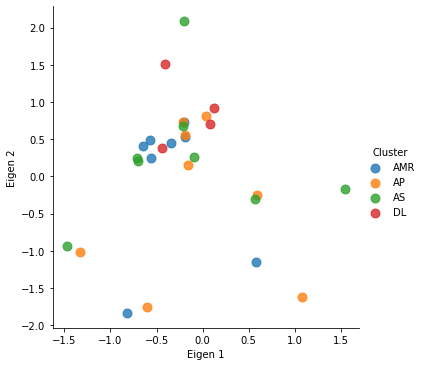

In [41]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [42]:
results = results.append({'subtask': 'person', 
                          'method': '1-raw', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: 0.180


# Method 2: Edges <a id='method2'></a>

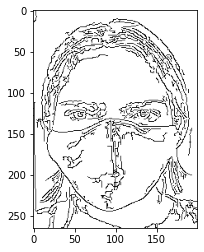

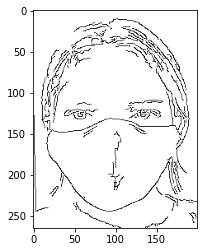

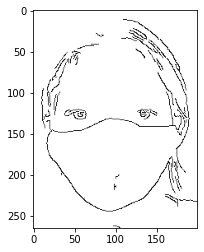

In [43]:
lower = [10, 30, 50]
upper = [50, 70, 100]

for l, u in zip(lower, upper):
    gray_image = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
    edged_image = cv2.Canny(gray_image, threshold1=l, threshold2=u)
    plt.imshow(edged_image, cmap = 'Greys')
    plt.show()

In [44]:
edged_images = np.zeros((265,200))

for img_file in img_files:
    gray_image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    edged_image = cv2.Canny(gray_image, threshold1=30, threshold2=70)
    edged_images = np.dstack((edged_images, edged_image))

edged_images = edged_images[:,:,1:]
edged_images = np.transpose(edged_images, (2, 0, 1))
n_samples, h, w = edged_images.shape
print(edged_images.shape)                

(112, 265, 200)


In [45]:
X = edged_images.reshape((112,-1))
n_features = X.shape[1]

In [46]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

## Subtask 1. Emotion recognition

In [47]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  4


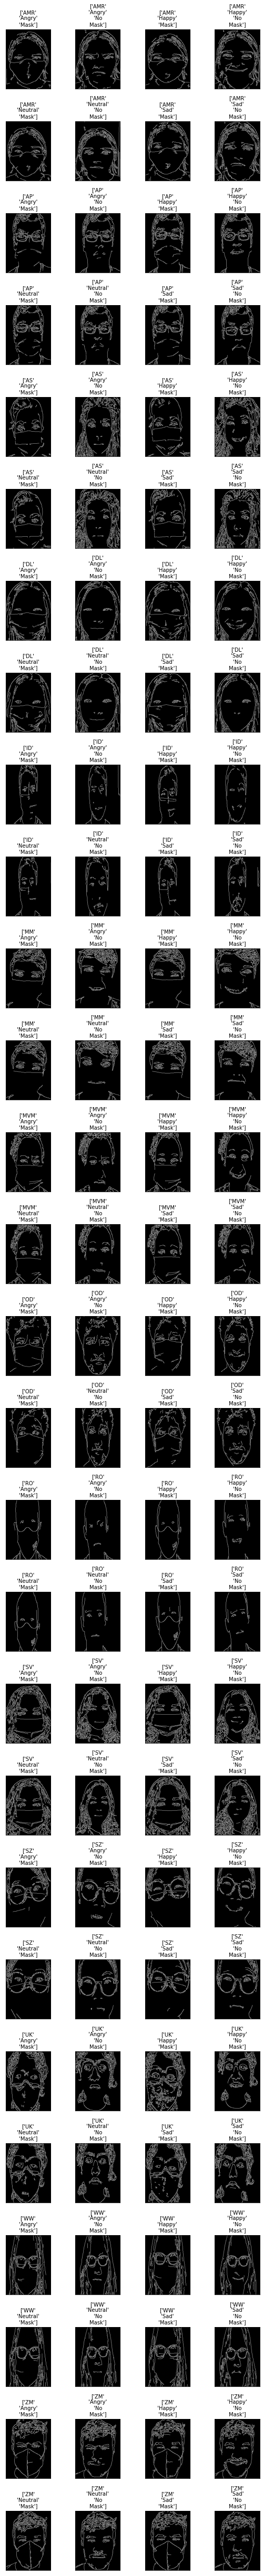

In [48]:
titles = np.array(data)
plot_gallery(X, titles, h, w)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


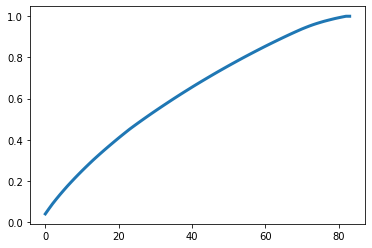

In [50]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [51]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [52]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.08      0.17      0.11         6
       Happy       0.15      0.25      0.19         8
     Neutral       0.00      0.00      0.00         8
         Sad       0.00      0.00      0.00         6

    accuracy                           0.11        28
   macro avg       0.06      0.10      0.08        28
weighted avg       0.06      0.11      0.08        28



In [53]:
predictions

array(['Angry', 'Happy', 'Happy', 'Angry', 'Angry', 'Happy', 'Angry',
       'Angry', 'Angry', 'Angry', 'Happy', 'Angry', 'Happy', 'Happy',
       'Sad', 'Happy', 'Angry', 'Happy', 'Happy', 'Sad', 'Happy', 'Angry',
       'Angry', 'Happy', 'Sad', 'Happy', 'Angry', 'Happy'], dtype=object)

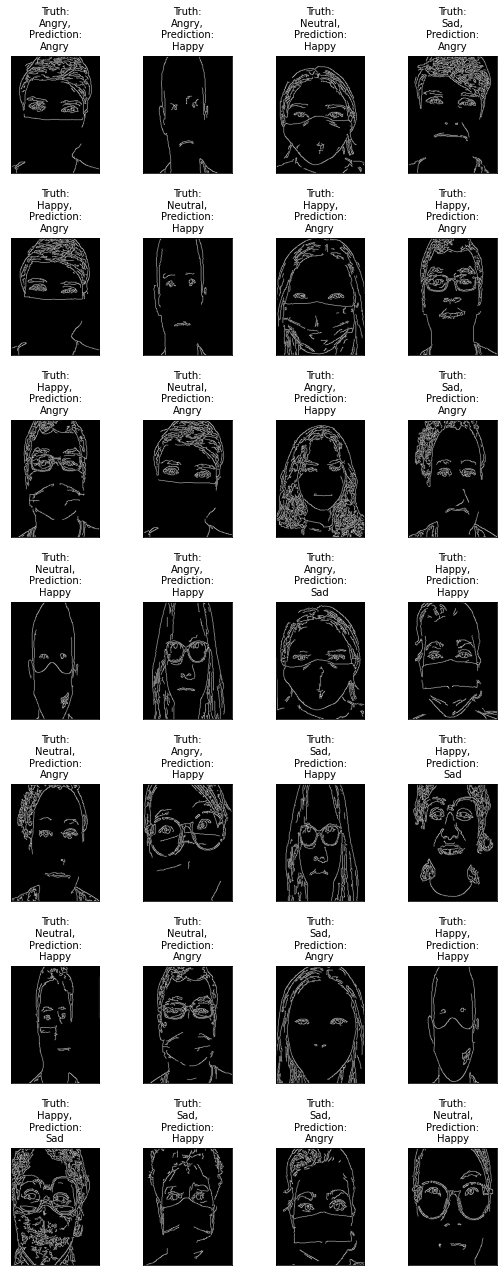

In [54]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

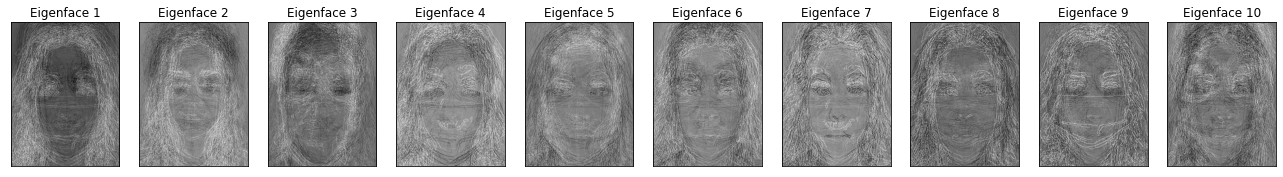

In [55]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

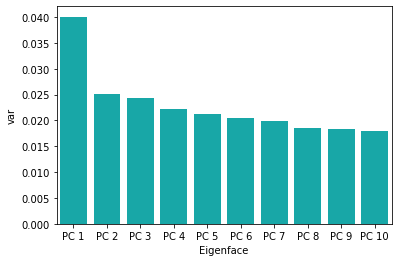

In [56]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [57]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.285763 -0.624907 -0.299841 -0.121890  0.222874 -0.339463 -0.060819   
1 -0.786411  0.613459 -0.222629  0.280196 -0.268126  0.117446  0.053872   
2  0.041979  0.334747 -0.112729 -0.284435  0.069377  0.386736  0.193965   
3 -0.294439 -0.956634 -0.191376 -0.120901  0.400010 -0.294435  0.109079   
4 -0.234482 -0.573735 -0.419246 -0.167881  0.267107 -0.345803  0.045146   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0  0.058117  0.325036 -0.224973    Angry  
1  0.070491 -0.062910  0.163108    Angry  
2 -0.201750 -0.218741  0.009527    Happy  
3  0.080455  0.387277 -0.084814    Happy  
4  0.107889  0.333502 -0.190777  Neutral

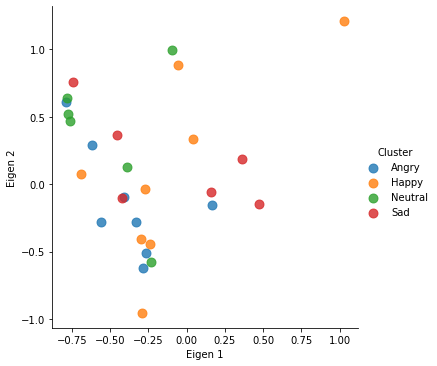

In [58]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [59]:
results = results.append({'subtask': 'emotion', 
                          'method': '2-edges', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: -0.010


## Subtask 2. Mask recognition

In [60]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  2


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [62]:
pca = PCA().fit(X_train)

In [63]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [64]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.59      0.62      0.61        16
     No Mask       0.45      0.42      0.43        12

    accuracy                           0.54        28
   macro avg       0.52      0.52      0.52        28
weighted avg       0.53      0.54      0.53        28



In [65]:
predictions

array(['Mask', 'No Mask', 'Mask', 'No Mask', 'Mask', 'Mask', 'Mask',
       'Mask', 'Mask', 'Mask', 'No Mask', 'Mask', 'No Mask', 'Mask',
       'Mask', 'Mask', 'Mask', 'No Mask', 'Mask', 'No Mask', 'No Mask',
       'Mask', 'Mask', 'No Mask', 'No Mask', 'No Mask', 'Mask', 'No Mask'],
      dtype=object)

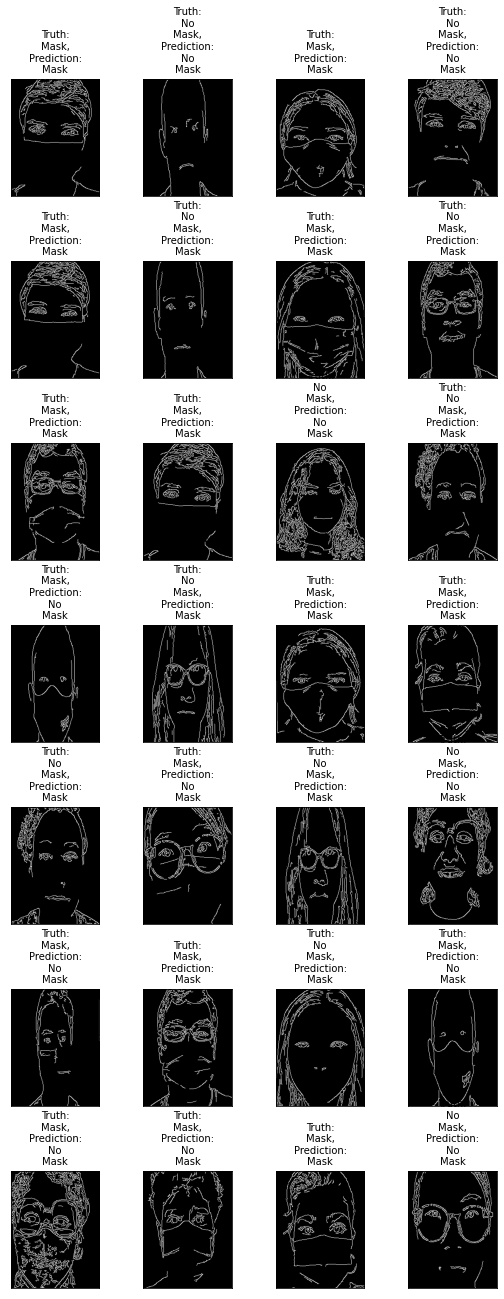

In [66]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

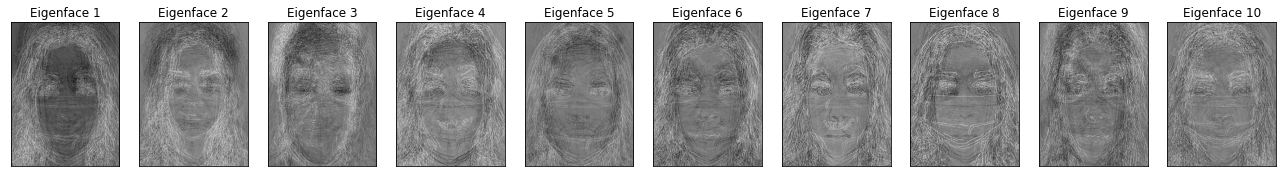

In [67]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

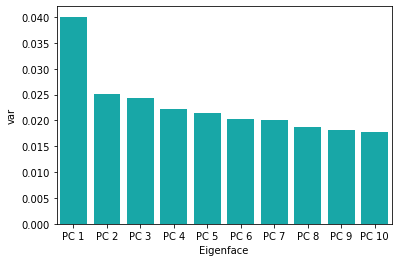

In [68]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [69]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.285618 -0.611116 -0.316557 -0.068300 -0.208179 -0.325751 -0.136862   
1 -0.788279  0.608439 -0.201703  0.273169  0.283888  0.096526  0.128580   
2  0.044043  0.330487 -0.081723 -0.361056 -0.110174  0.404840  0.314399   
3 -0.291791 -0.959761 -0.168457 -0.021375 -0.408252 -0.334812 -0.021351   
4 -0.234178 -0.565383 -0.433908 -0.103234 -0.274535 -0.366996 -0.040466   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0  0.222663 -0.230094  0.275713     Mask  
1 -0.032142  0.177105  0.019435  No Mask  
2  0.082137 -0.063308 -0.096912     Mask  
3  0.139416 -0.068150  0.326190  No Mask  
4  0.216301 -0.236589  0.381100     Mask

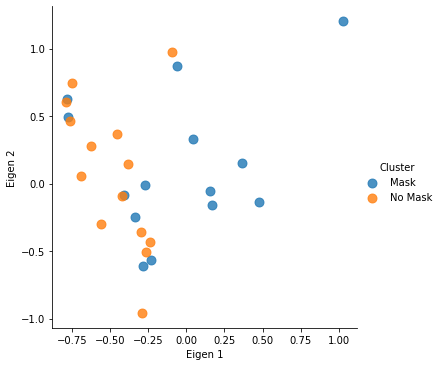

In [70]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [71]:
results = results.append({'subtask': 'mask', 
                          'method': '2-edges', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: 0.000


## Subtask 3. Person recognition

In [72]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  14


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [74]:
pca = PCA().fit(X_train)

In [75]:
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [76]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       1.00      1.00      1.00         2
          AP       0.00      0.00      0.00         3
          AS       0.00      0.00      0.00         2
          DL       1.00      1.00      1.00         2
          ID       0.12      1.00      0.22         1
          MM       1.00      0.25      0.40         4
         MVM       0.22      1.00      0.36         2
          OD       0.20      1.00      0.33         1
          RO       0.00      0.00      0.00         4
          SV       0.00      0.00      0.00         1
          SZ       0.00      0.00      0.00         2
          UK       0.00      0.00      0.00         2
          WW       0.00      0.00      0.00         2

    accuracy                           0.32        28
   macro avg       0.27      0.40      0.26        28
weighted avg       0.31      0.32      0.25        28



In [77]:
predictions

array(['MVM', 'ID', 'AMR', 'MM', 'MVM', 'ID', 'DL', 'MVM', 'MVM', 'MVM',
       'WW', 'MVM', 'ID', 'ID', 'AMR', 'ID', 'MVM', 'OD', 'ID', 'OD',
       'ID', 'MVM', 'DL', 'ID', 'OD', 'OD', 'MVM', 'OD'], dtype=object)

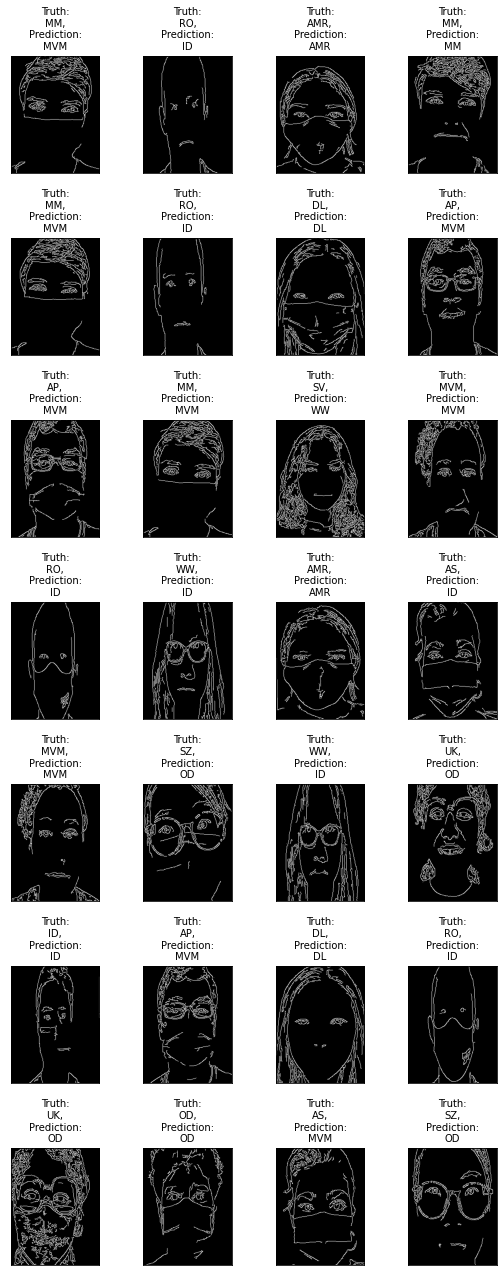

In [78]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

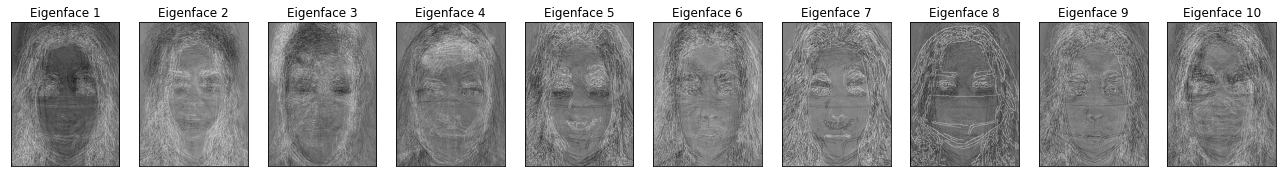

In [79]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

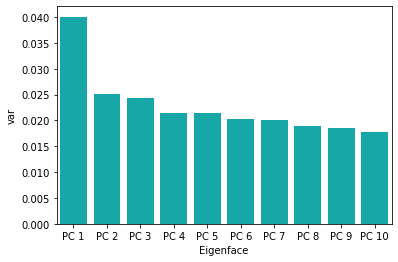

In [80]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [81]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.286188 -0.630069 -0.317676  0.186088  0.113745 -0.338393 -0.001519   
1 -0.787100  0.618146 -0.213195 -0.385245  0.054251  0.200872  0.003158   
2  0.043967  0.360453 -0.091647  0.380789 -0.412930  0.365594 -0.245783   
3 -0.295750 -0.991839 -0.170730  0.357875  0.299008 -0.272324 -0.078392   
4 -0.234954 -0.576410 -0.439853  0.256705  0.122449 -0.311291 -0.102803   

    Eigen 8   Eigen 9  Eigen 10 Cluster  
0  0.258704  0.209200  0.064182     AMR  
1 -0.021488 -0.112821 -0.100428     AMR  
2 -0.033736 -0.154111  0.174534     AMR  
3  0.245959  0.265068 -0.223017     AMR  
4  0.274480  0.248744  0.033021     AMR

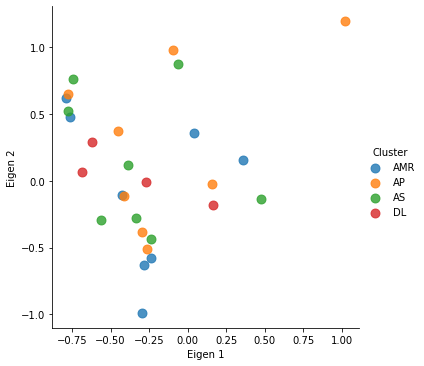

In [82]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [83]:
results = results.append({'subtask': 'person', 
                          'method': '2-edges', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: -0.110


In [84]:
results.sort_values('subtask')

subtask   method  silhouette_score
0  emotion    1-raw         -0.036860
3  emotion  2-edges         -0.010019
1     mask    1-raw          0.005638
4     mask  2-edges          0.000223
2   person    1-raw          0.179526
5   person  2-edges         -0.109766

# Method 3: Crop <a id='method3'></a>

In [85]:
math.ceil(img0.shape[1]/2)

100

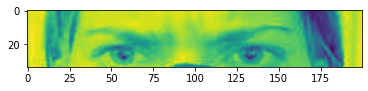

In [86]:
plt.imshow(img0[math.ceil(img0.shape[1]*(1/2)): math.ceil(img0.shape[1]*(2/3)),:])

In [87]:
scale1 = (1/3)
scale2 = (4/5)

cropped_images = np.zeros((265,200))
cropped_images = cropped_images[math.ceil(img0.shape[1]*scale1): math.ceil(img0.shape[1]*scale2),:]

for img_file in img_files:
    gray_image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    cropped_image = gray_image[math.ceil(gray_image.shape[1]*scale1): math.ceil(gray_image.shape[1]*scale2),:]
    cropped_images = np.dstack((cropped_images, cropped_image))

cropped_images = cropped_images[:,:,1:]
cropped_images = np.transpose(cropped_images, (2, 0, 1))
n_samples, h, w = cropped_images.shape
print(cropped_images.shape)                

(112, 93, 200)


In [88]:
X = cropped_images.reshape((112,-1))
n_features = X.shape[1]
print(X.shape)

(112, 18600)


In [89]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

## Subtask 1. Emotion recognition

In [90]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  18600
Number of Class Labels:  4


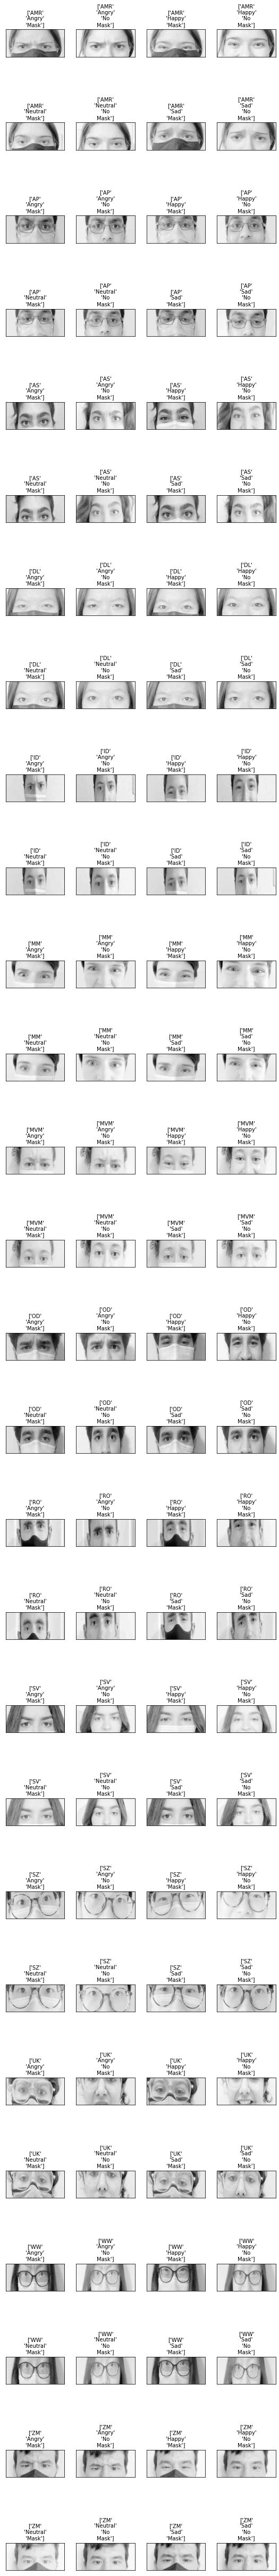

In [91]:
titles = np.array(data)
plot_gallery(X, titles, h, w)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


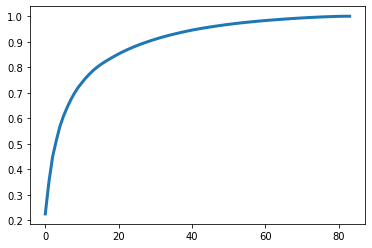

In [93]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [94]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [95]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.08      0.17      0.11         6
       Happy       0.00      0.00      0.00         8
     Neutral       0.00      0.00      0.00         8
         Sad       0.00      0.00      0.00         6

    accuracy                           0.04        28
   macro avg       0.02      0.04      0.03        28
weighted avg       0.02      0.04      0.02        28



In [96]:
predictions

array(['Sad', 'Angry', 'Sad', 'Angry', 'Sad', 'Happy', 'Angry', 'Sad',
       'Angry', 'Angry', 'Neutral', 'Angry', 'Angry', 'Neutral', 'Sad',
       'Angry', 'Happy', 'Sad', 'Neutral', 'Angry', 'Sad', 'Sad', 'Angry',
       'Sad', 'Neutral', 'Angry', 'Angry', 'Sad'], dtype=object)

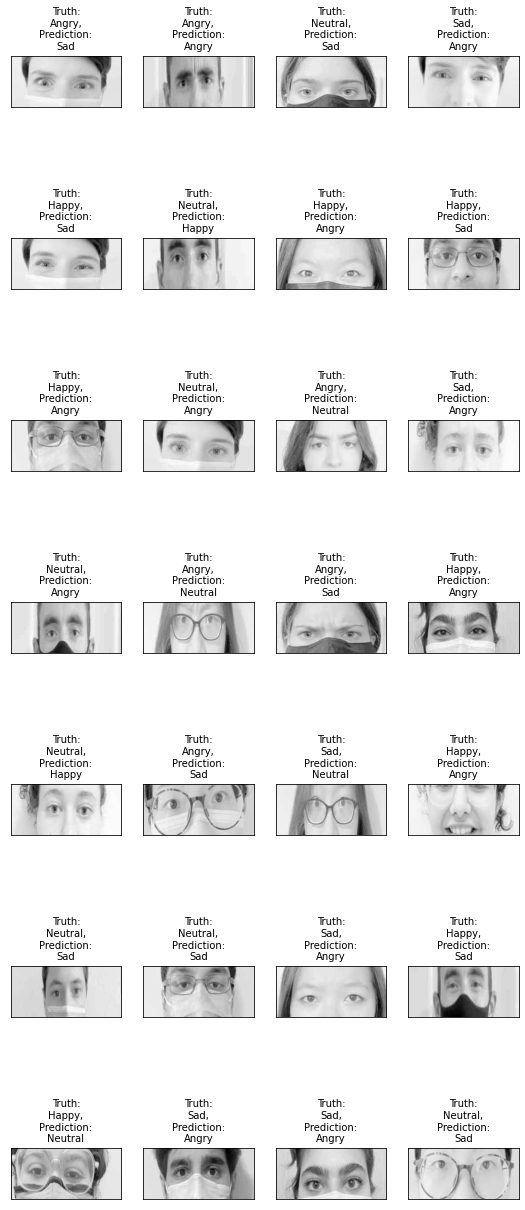

In [97]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

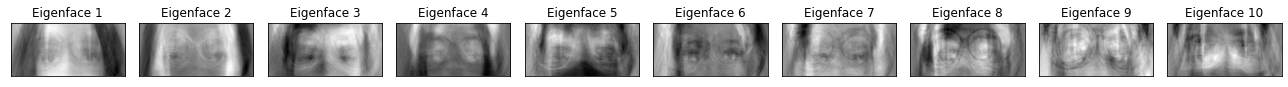

In [98]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

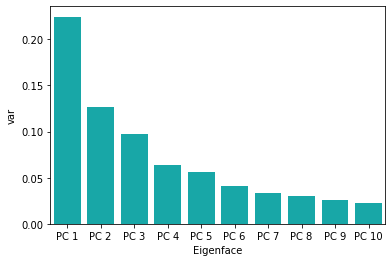

In [99]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [100]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0  0.385322 -0.338302 -1.200862 -1.586121  0.820767 -1.266436 -0.213716   
1 -1.230931  0.566654  0.118318  1.000816 -0.541626  0.744559  0.785063   
2  0.083186 -0.125620 -0.321582  1.286000  2.195862 -1.609837  0.051888   
3 -0.377919  0.227250 -0.358685 -1.323464 -0.593377 -0.784864 -0.918086   
4  0.335141 -0.521502 -1.013752 -1.402232  0.857076 -1.517379  0.512080   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0 -2.369153 -0.229797 -0.209242    Angry  
1 -0.178368 -0.525996  0.345451    Angry  
2 -0.974428 -0.474344 -0.340896    Happy  
3 -1.202163 -0.476605  0.890850    Happy  
4 -1.958817 -0.523597 -0.071119  Neutral

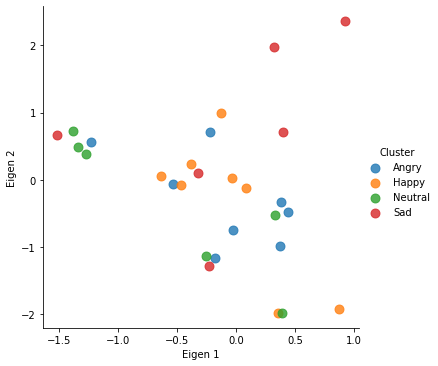

In [101]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [102]:
results = results.append({'subtask': 'emotion', 
                          'method': '3-crop', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: -0.032


## Subtask 2. Mask recognition

In [103]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  18600
Number of Class Labels:  2


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [105]:
pca = PCA().fit(X_train)

In [106]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [107]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.90      0.56      0.69        16
     No Mask       0.61      0.92      0.73        12

    accuracy                           0.71        28
   macro avg       0.76      0.74      0.71        28
weighted avg       0.78      0.71      0.71        28



In [108]:
predictions

array(['Mask', 'No Mask', 'Mask', 'No Mask', 'Mask', 'No Mask', 'Mask',
       'No Mask', 'No Mask', 'Mask', 'No Mask', 'No Mask', 'No Mask',
       'No Mask', 'Mask', 'No Mask', 'No Mask', 'No Mask', 'No Mask',
       'Mask', 'No Mask', 'No Mask', 'No Mask', 'Mask', 'Mask', 'No Mask',
       'Mask', 'No Mask'], dtype=object)

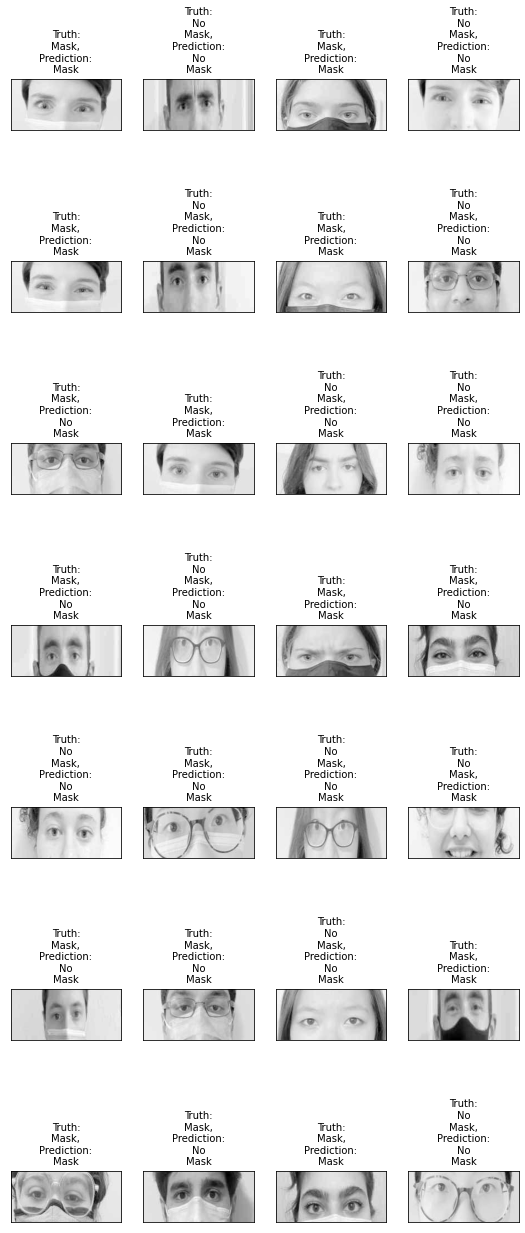

In [109]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

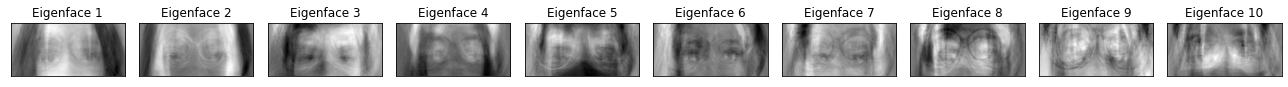

In [110]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

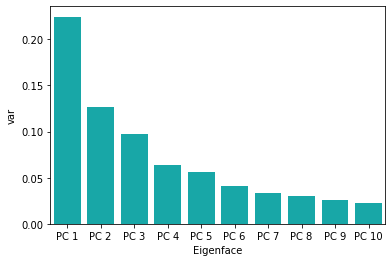

In [111]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [112]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0  0.385322 -0.338304 -1.200849 -1.586167  0.820822 -1.266506 -0.214470   
1 -1.230931  0.566653  0.118322  1.000807 -0.541594  0.744414  0.785178   
2  0.083186 -0.125621 -0.321583  1.285993  2.195907 -1.609596  0.052178   
3 -0.377919  0.227252 -0.358679 -1.323463 -0.593289 -0.784468 -0.918349   
4  0.335141 -0.521503 -1.013742 -1.402255  0.857058 -1.517829  0.511512   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0 -2.370643 -0.232820 -0.213287     Mask  
1 -0.178579 -0.528730  0.343544  No Mask  
2 -0.974213 -0.471511 -0.332491     Mask  
3 -1.201435 -0.477446  0.879067  No Mask  
4 -1.961531 -0.527734 -0.071417     Mask

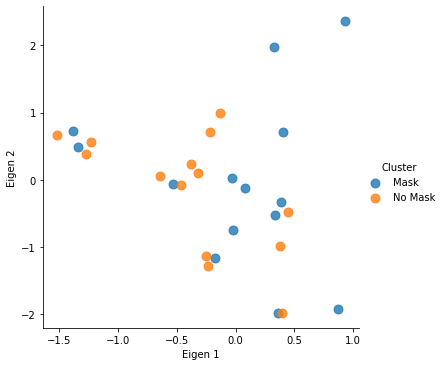

In [113]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [114]:
results = results.append({'subtask': 'mask', 
                          'method': '3-crop', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: 0.001


## Subtask 3. Person recognition

In [115]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  18600
Number of Class Labels:  14


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [117]:
pca = PCA().fit(X_train)

In [118]:
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [119]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       1.00      1.00      1.00         2
          AP       0.00      0.00      0.00         3
          AS       0.00      0.00      0.00         2
          DL       1.00      1.00      1.00         2
          ID       1.00      1.00      1.00         1
          MM       1.00      0.50      0.67         4
         MVM       0.50      1.00      0.67         2
          OD       0.17      1.00      0.29         1
          RO       1.00      1.00      1.00         4
          SV       1.00      1.00      1.00         1
          SZ       1.00      1.00      1.00         2
          UK       1.00      0.50      0.67         2
          WW       1.00      1.00      1.00         2

    accuracy                           0.71        28
   macro avg       0.74      0.77      0.71        28
weighted avg       0.76      0.71      0.70        28



In [120]:
predictions

array(['MM', 'RO', 'AMR', 'MM', 'OD', 'RO', 'DL', 'OD', 'OD', 'OD', 'SV',
       'MVM', 'RO', 'WW', 'AMR', 'MVM', 'MVM', 'SZ', 'WW', 'UK', 'ID',
       'OD', 'DL', 'RO', 'AS', 'OD', 'MVM', 'SZ'], dtype=object)

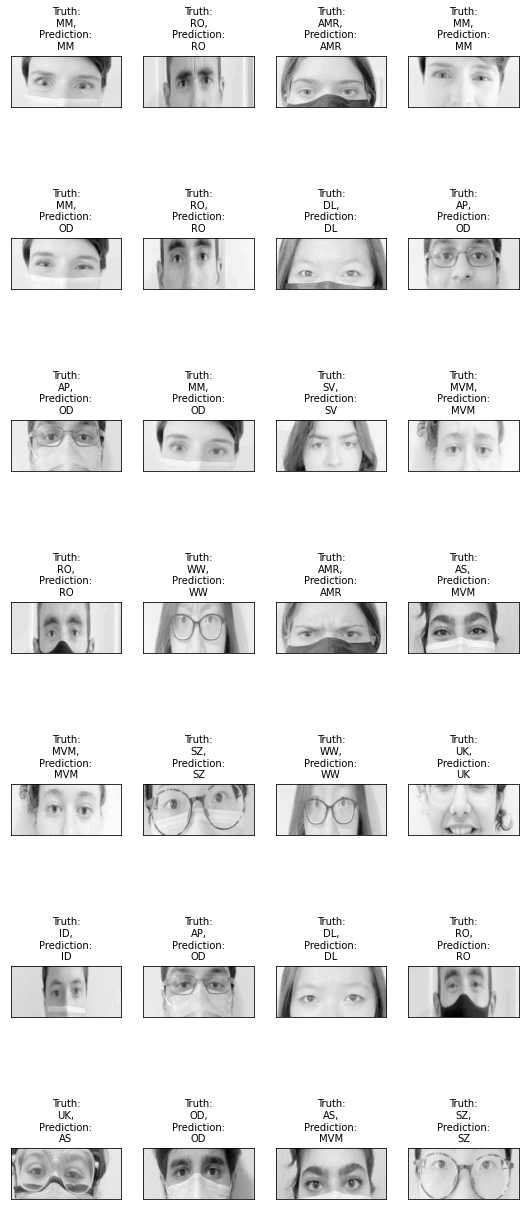

In [121]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

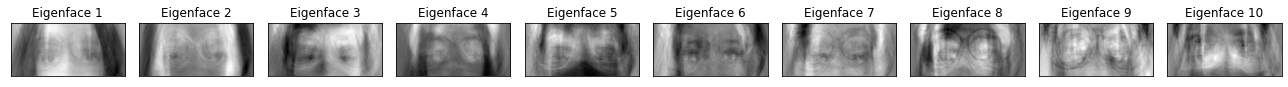

In [122]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

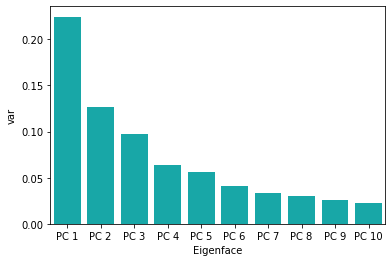

In [123]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [145]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0  0.385322 -0.338308 -1.200844 -1.586220  0.820776 -1.266825 -0.212645   
1 -1.230931  0.566654  0.118321  1.000817 -0.541613  0.744623  0.784808   
2  0.083187 -0.125623 -0.321579  1.285968  2.195876 -1.610015  0.052429   
3 -0.377919  0.227244 -0.358664 -1.323543 -0.593422 -0.785898 -0.915502   
4  0.335141 -0.521509 -1.013734 -1.402345  0.857048 -1.517893  0.513067   

    Eigen 8   Eigen 9  Eigen 10 Cluster  
0 -2.367711 -0.224189 -0.220359     AMR  
1 -0.178191 -0.526754  0.346655     NaN  
2 -0.973891 -0.467378 -0.342916     NaN  
3 -1.201086 -0.471032  0.862785     NaN  
4 -1.957074 -0.516191 -0.085419     AMR

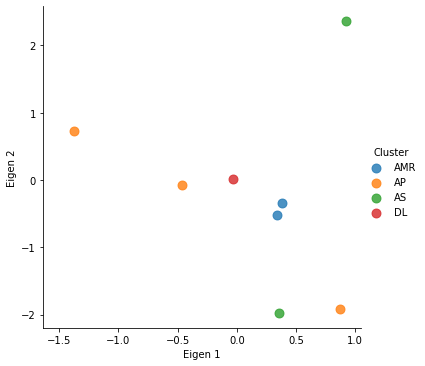

In [146]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [126]:
results = results.append({'subtask': 'person', 
                          'method': '3-crop', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']))

Silhouette Coefficient: 0.145


In [135]:
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster'])

-0.20498740445900743

# Report <a id='report'></a>

For this assignment, I used PCA to decompose 112 face images into 10 eigenfaces. I tried finding the optimal number of components to use to reach 80% accuracy, but decided instead that I wanted to keep the number of components the same to be able to compare each of the image preprocessing methods easier. I used the silhouette score to evaluate PCA performance after three preprocessing alternatives:

1) raw grayscale images <br>
2) image edges <br>
3) cropped images (focusing on eye to lip area) <br>

For the emotion subtask, the silhouette score was lowest when PCA was applied on the grayscale images. Cropped images yielded the second best performance, with edge images yielding the worst performance. This suggests that the algorithm was best able to make use of the full grayscale image in order to provide information about the emotion. It could be that a different edge threshold would have produced better results. Several edge thresholds were piloted, and I selected the one that I thought conveyed useful information but minimized extraneous information. It could be that the algorithm has a different idea about what constitutes useful information.


In [132]:
results[results['subtask'] == 'emotion'].sort_values(['silhouette_score'], ascending=True)

subtask   method  silhouette_score
0  emotion    1-raw         -0.036860
6  emotion   3-crop         -0.031865
3  emotion  2-edges         -0.010019

For the mask classification, the edge images yielded the best PCA performance, followed by the cropped images, followed by the raw. Because the mask is a fairly large, undetailed object, it could be that using the edges maximized the amount of information available about the mask presence over and above what the raw or cropped images provided. It was interesting to me that the cropped images performed better than the raw images here, since the majority of the mask area was removed. The remaining pixels containing mask vs. no mask data remained sufficient, and even relatively more useful, for the classification task.

In [133]:
results[results['subtask'] == 'mask'].sort_values(['silhouette_score'], ascending=True)

subtask   method  silhouette_score
4    mask  2-edges          0.000223
7    mask   3-crop          0.000991
1    mask    1-raw          0.005638

Similar results were obtained for person classification as were found for the mask classification. Again, PCA performed on the edge images yielded the best results, followed by the cropped images, followed by the raw images.

In [134]:
results[results['subtask'] == 'person'].sort_values(['silhouette_score'], ascending=True)

subtask   method  silhouette_score
5  person  2-edges         -0.109766
8  person   3-crop          0.145247
2  person    1-raw          0.179526

In addition to using the silhouette score, I also fed the PCA results to a SVM classifier and used that to give predictive labels to images in the training dataset.

# References

[Sandipanweb Eigenfaces Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)